### Membuat pola spasial kesejahteraan Rumah Tangga di Kabupaten Probolinggo
<p style="text-align: justify;">Notebook ini mendemonstrasikan pemetaan pola spasial tingkat kesejahteraan Rumah Tangga di Kabupaten Probolinggo yang dihasilkan dari dataset RWI menggunakan Python. Kita akan menggunakan pandas untuk manipulasi data, geopandas untuk operasi spasial, matplotlib untuk plotting, dan contextily untuk menambahkan peta dasar.<br>

**Tentang Dataset RWI dari META** <br>
Relative Wealth Index (RWI) adalah dataset yang dikembangkan oleh META (sebelumnya Facebook) bekerja sama dengan Center for International Earth Science Information Network (CIESIN) di Columbia University. Dataset ini menyediakan estimasi tingkat kesejahteraan (wealth) relatif untuk area geografis kecil di seluruh dunia, termasuk Indonesia.<br>
Beberapa poin penting tentang dataset RWI:

1. Metodologi: RWI dihasilkan menggunakan kombinasi dari citra satelit beresolusi tinggi, data survei, dan machine learning.
2. Skala: Data tersedia pada resolusi grid 2.4km x 2.4km, memberikan gambaran detail tentang variasi tingkat kesejahteraan (wealth) suatu wilayah.
3. Interpretasi: Nilai RWI berkisar dari 0 hingga 100, di mana nilai yang lebih tinggi menunjukkan tingkat kekayaan relatif yang lebih tinggi.
4. Kegunaan: Dataset ini sangat berguna untuk berbagai aplikasi, salah satunya untuk memberikan dimensi spasial terhadap tingkat kesejahteraan suatu wilayah.

<br>Dalam analisis ini, kita akan menggunakan dataset RWI dalam memetakan tingkat kesejahteraan Rumah Tangga (RT) untuk mendapatkan wawasan tentang pola spasial kesejahteraan ekonomi di wilayah Kabupaten Probolinggo.

**Mengimpor Pustaka yang Diperlukan** 
<br>Pustaka-pustaka ini penting untuk analisis kita:

- pandas: Untuk manipulasi dan analisis data
- geopandas: Untuk bekerja dengan data geospasial
- matplotlib.pyplot: Untuk membuat plot dan visualisasi
- contextily: Untuk menambahkan peta dasar ke plot kita

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

**Memuat dan Menyiapkan Data**
<br>Di sini, kita melakukan dua hal utama:

1. Memuat data RWI dari file CSV dan mengubahnya menjadi GeoDataFrame dengan geometri titik.
2. Memuat data batas administratif Probolinggo dari file GeoJSON.

In [3]:
# load data RWI
df = pd.read_csv(r'E:\Project\GH\spasialRWI\idn_relative_wealth_index.csv')
gdf_points = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

# Memuat geojson untuk batas administratif
gdf_probolinggo = gpd.read_file(r'E:\Project\GH\spasialRWI\35.13.geojson')

**Memproyeksikan Ulang Data**
<br>Kita memproyeksikan ulang kedua dataset ke EPSG:3857 (proyeksi Web Mercator). <br>
Ini penting untuk operasi spasial dan visualisasi yang akurat.

In [3]:
# Memproyeksikan ulang data ke sistem koordinat yang sesuai
gdf_points = gdf_points.to_crs(epsg=3857)
gdf_probolinggo = gdf_probolinggo.to_crs(epsg=3857)

**Penggabungan Spasial**
<br>Operasi ini melakukan penggabungan spasial untuk menyaring hanya titik-titik RWI yang berada dalam batas Probolinggo.<br>

In [4]:
# Penggabungan spasial untuk mendapatkan nilai RWI pada peta Probolinggo
gdf_points_in_probolinggo = gpd.sjoin(gdf_points, gdf_probolinggo, how="inner", predicate="within")

**Fungsi Pembantu untuk Batas Plot**
<br>Fungsi ini membantu mengatur batas plot dengan menambahkan sedikit padding di sekitar area geografis yang menjadi fokus.<br>

In [5]:
def set_plot_bounds(ax, gdf, padding=0.1):
    bounds = gdf.total_bounds
    width = bounds[2] - bounds[0]
    height = bounds[3] - bounds[1]
    ax.set_xlim(bounds[0] - width * padding, bounds[2] + width * padding)
    ax.set_ylim(bounds[1] - height * padding, bounds[3] + height * padding)

**Membuat Peta**
<br>Bagian ini membuat peta akhir:

1. Menyiapkan plot dengan ukuran yang ditentukan.
2. Memplot batas Probolinggo.
3. Memplot titik-titik RWI, diwarnai berdasarkan nilai RWI-nya.
4. Mengatur batas plot menggunakan fungsi pembantu kita.
5. Menambahkan judul dan label.
6. Menambahkan peta dasar OpenStreetMap untuk konteks.
7. Menekankan batas Probolinggo.
8. Menampilkan plot.

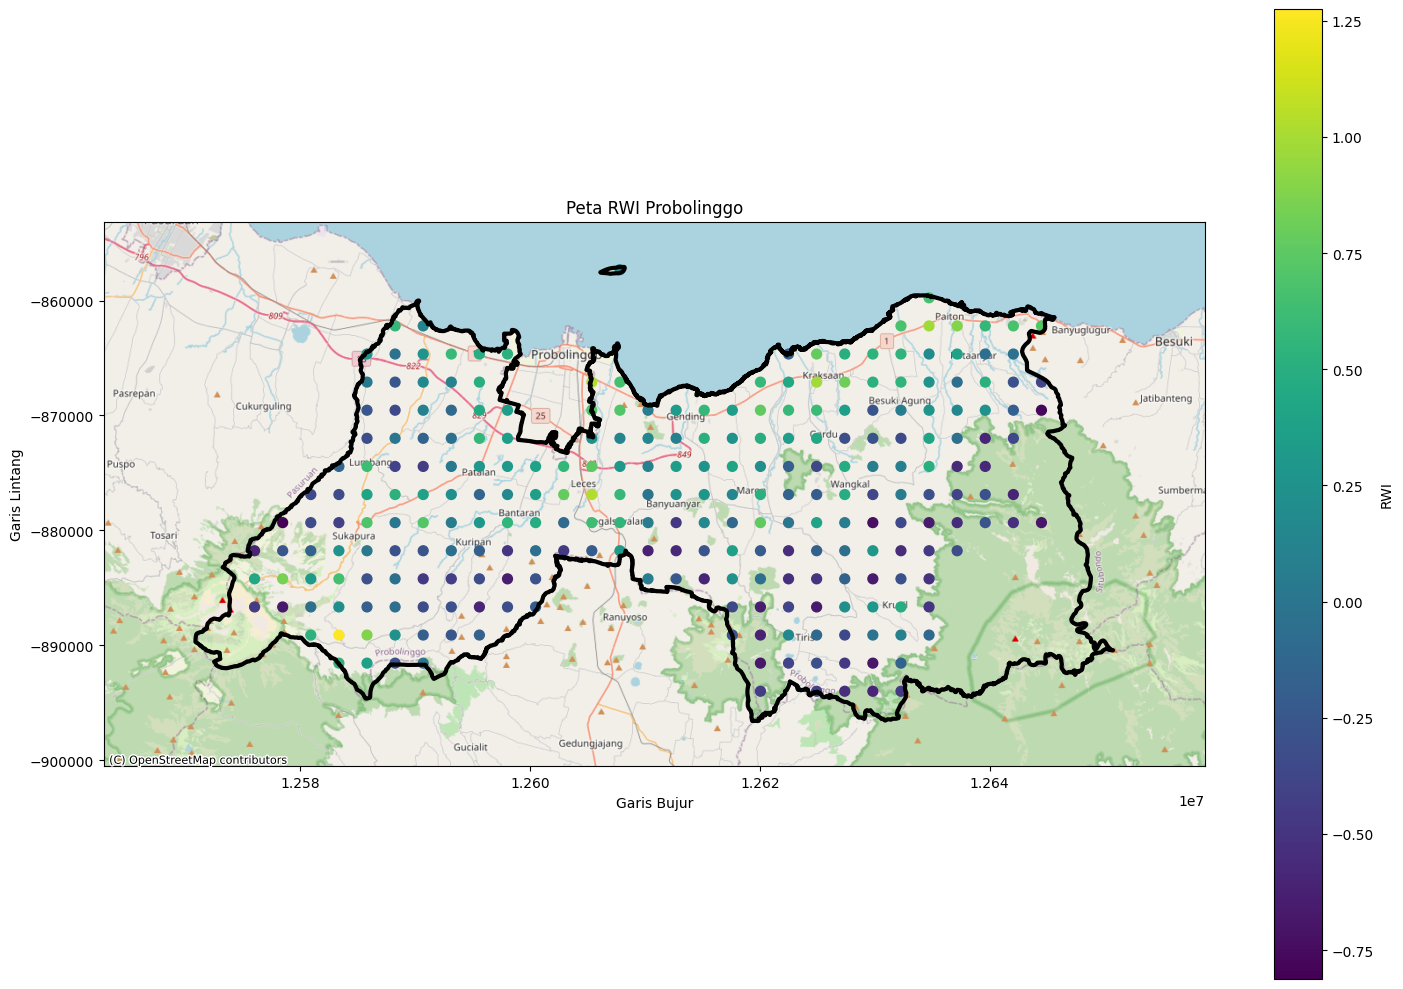

In [6]:
# Plot peta RWI Probolinggo
fig, ax = plt.subplots(figsize=(15, 10))
gdf_probolinggo.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
gdf_points_in_probolinggo.plot(ax=ax, column='rwi', cmap='viridis', 
                              legend=True, legend_kwds={'label': 'RWI'},
                              markersize=50)
set_plot_bounds(ax, gdf_probolinggo, padding=0.1)
plt.title('Peta RWI Probolinggo')
plt.xlabel('Garis Bujur')
plt.ylabel('Garis Lintang')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=11)
gdf_probolinggo.boundary.plot(ax=ax, color='black', linewidth=3)
plt.tight_layout()
plt.show()

**SELANJUTNYA (eksplorasi lanjutan)**
- memplot batas Kecamatan/Desa untuk memberi konteks spasial yang lebih rinci.
- Menyediakan analisis Statistik tambahan per Kecamatan
- menambahkan visualisasi untuk menampilkan statistik RWI per wilayah, misalnya menggunakan plot bar atau choropleth.
- Menggabungkan High Resolution Population Density Maps versi Indonesia dari META
